In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, ReLU, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K

df = pd.read_csv('data.csv')

In [22]:
data = df.drop(columns=['id', 'label1', 'label2']).values

mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
std[std == 0] = 1
data = (data - mean) / std

assert not np.any(np.isnan(data)), "Data contains NaNs"

input_dim = data.shape[1]
latent_dim = 20
intermediate_dim = 256

# Encoder network
inputs = Input(shape=(input_dim,))
h = Dense(intermediate_dim)(inputs)
h = BatchNormalization()(h)
h = LeakyReLU()(h)
h = Dense(intermediate_dim // 2)(h)
h = BatchNormalization()(h)
h = LeakyReLU()(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

decoder_h1 = Dense(intermediate_dim // 2, activation='relu')
decoder_h2 = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')
h_decoded = decoder_h1(z)
h_decoded = decoder_h2(h_decoded)
x_decoded_mean = decoder_mean(h_decoded)

vae = Model(inputs, x_decoded_mean)

reconstruction_loss = mse(inputs, x_decoded_mean) * input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.0))

vae.fit(data, epochs=200, batch_size=64, validation_split=0.2)

def generate_synthetic_data(num_samples):
    z_sample = np.random.normal(size=(num_samples, latent_dim))
    x_decoded = decoder_mean(decoder_h2(decoder_h1(z_sample)))
    return x_decoded.numpy()

synthetic_data = generate_synthetic_data(5000)

Epoch 1/200
258/258 [==============================] - 5s 6ms/step - loss: 19.7535 - val_loss: 17.8591
Epoch 2/200
258/258 [==============================] - 1s 5ms/step - loss: 17.8908 - val_loss: 17.5972
Epoch 3/200
258/258 [==============================] - 1s 5ms/step - loss: 17.6426 - val_loss: 17.5300
Epoch 4/200
258/258 [==============================] - 1s 5ms/step - loss: 17.2941 - val_loss: 17.0755
Epoch 5/200
258/258 [==============================] - 1s 5ms/step - loss: 16.8734 - val_loss: 16.5788
Epoch 6/200
258/258 [==============================] - 2s 9ms/step - loss: 16.7267 - val_loss: 16.4348
Epoch 7/200
258/258 [==============================] - 2s 10ms/step - loss: 16.4651 - val_loss: 16.3056
Epoch 8/200
258/258 [==============================] - 1s 6ms/step - loss: 16.4407 - val_loss: 16.2990
Epoch 9/200
258/258 [==============================] - 1s 5ms/step - loss: 16.4152 - val_loss: 16.3632
Epoch 10/200
258/258 [==============================] - 1s 6ms/step - lo

In [23]:
synthetic_data_df = pd.DataFrame(synthetic_data, columns=df.drop(columns=['id', 'label1', 'label2']).columns)
synthetic_data_df

,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
0,2.057990e-01,0.009210,8.850847e-03,1.146606e-05,8.670431e-06,3.231089e-01,2.174707e-01,3.002052e-01,9.024291e-06,1.347704e-01,...,0.000276,3.172175e-01,1.526926e-05,2.061160e-01,1.213347e-05,1.329364e-05,2.417966e-08,1.710061e-08,9.476498e-07,2.042757e-01
1,9.956678e-01,0.011411,4.421980e-04,6.574545e-06,5.531325e-06,9.124435e-01,9.219228e-01,9.686866e-01,1.755873e-05,1.590133e-01,...,0.994849,9.515203e-01,1.454889e-05,9.365099e-01,8.903833e-06,2.046547e-05,2.819401e-14,1.039983e-14,5.498990e-20,9.950302e-01
2,7.124056e-09,0.004651,1.261149e-08,9.785649e-10,1.020329e-10,5.293459e-18,8.315241e-18,3.661319e-18,1.254385e-09,4.509505e-06,...,0.000100,2.658117e-17,2.438808e-09,2.340792e-17,6.697217e-10,8.072799e-09,7.089892e-01,7.020146e-01,5.658649e-01,2.152556e-09
3,2.616423e-05,0.004697,2.908905e-09,9.821559e-08,2.002272e-08,9.233757e-15,8.134383e-15,1.088829e-14,9.190477e-08,8.013600e-06,...,0.019378,2.937837e-14,2.487120e-07,2.888254e-14,5.066121e-08,6.755939e-07,5.974867e-01,6.165697e-01,2.816168e-01,1.611546e-05
4,3.033610e-10,0.001033,1.407501e-11,1.230847e-12,4.565911e-14,3.730545e-24,1.524748e-23,1.497996e-24,2.096862e-12,1.989103e-10,...,0.000206,4.805216e-23,4.724306e-12,6.080041e-23,6.401462e-13,3.057419e-11,9.499010e-01,9.535877e-01,7.185456e-01,5.095467e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.932339e-08,0.011601,2.502554e-06,2.381819e-08,3.442079e-09,2.474553e-14,1.601258e-14,2.427459e-14,3.047381e-08,6.982011e-04,...,0.000011,8.932530e-14,4.823848e-08,3.448451e-14,2.244089e-08,9.458948e-08,5.776109e-01,5.430352e-01,5.764381e-01,7.470876e-09
4996,4.105007e-07,0.018054,8.003350e-05,4.173314e-06,1.881886e-06,3.750808e-09,8.962670e-10,5.176445e-09,4.910974e-06,3.956728e-02,...,0.000010,4.423216e-09,5.625700e-06,1.362337e-09,4.197818e-06,6.848509e-06,3.146693e-01,3.109026e-01,3.641385e-01,2.781638e-07
4997,5.677464e-01,0.010111,1.873223e-03,8.055908e-05,7.331396e-05,3.543221e-01,3.217762e-01,3.603281e-01,9.977103e-05,1.479466e-01,...,0.348342,3.472917e-01,9.051884e-05,3.247316e-01,9.510780e-05,1.115486e-04,1.496468e-07,1.338767e-07,5.564667e-10,5.683137e-01
4998,2.529254e-09,0.007785,3.011967e-07,2.997617e-09,3.252597e-10,3.778828e-16,2.948190e-16,3.058858e-16,4.335555e-09,8.925064e-05,...,0.000003,1.568660e-15,5.867325e-09,7.063443e-16,2.330031e-09,1.693598e-08,6.372180e-01,6.222843e-01,6.088504e-01,8.009147e-10


In [10]:
data_df = pd.DataFrame(data, columns=df.drop(columns=['id', 'label1', 'label2']).columns)
data_df

,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
0,1.0,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,...,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191.0,0.000000
1,2.0,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,...,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190.0,0.002770
2,3.0,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,...,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189.0,0.005540
3,4.0,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,...,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188.0,0.008310
4,5.0,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,...,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187.0,0.011080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,196.0,0.477011,0.250000,0.0,0.0,0.686747,0.587312,0.782917,0.0,1.0,...,0.194344,0.656791,0.0,0.750000,0.0,0.0,0.271318,0.109500,4.0,0.540166
20627,197.0,0.408046,0.083333,0.0,0.0,0.701807,0.729453,0.866475,0.0,1.0,...,0.188668,0.727203,0.0,0.583333,0.0,0.0,0.124031,0.366197,3.0,0.542936
20628,198.0,0.522989,0.500000,0.0,0.0,0.665663,0.684979,0.775321,0.0,1.0,...,0.212148,0.922278,0.0,0.833333,0.0,0.0,0.232558,0.053991,2.0,0.545706
20629,199.0,0.436782,0.750000,0.0,0.0,0.608434,0.746021,0.747468,0.0,1.0,...,0.203065,0.823394,0.0,0.583333,0.0,0.0,0.116279,0.234466,1.0,0.548476


In [25]:
output_file_path = "vae.csv"

synthetic_data_df.to_csv(output_file_path, index=False)
print(f"Data saved to {output_file_path}")

Data saved to vae.csv


In [3]:
!pip install table_evaluator

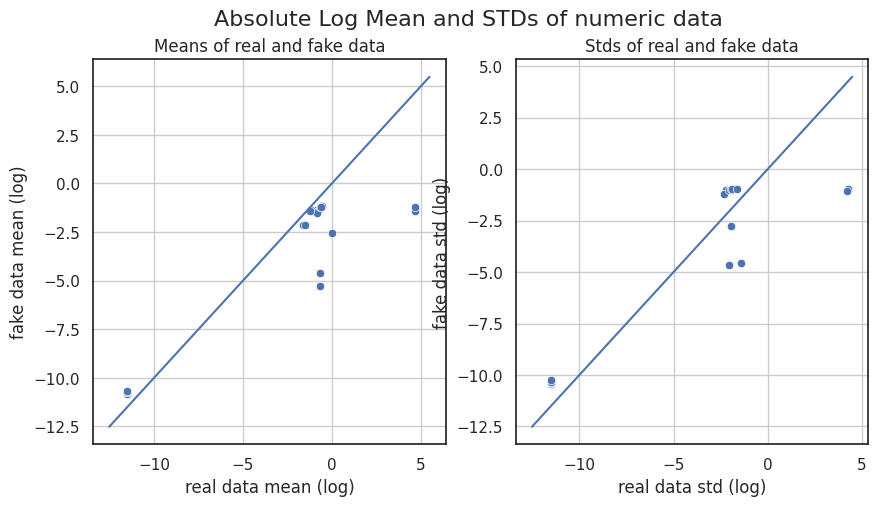

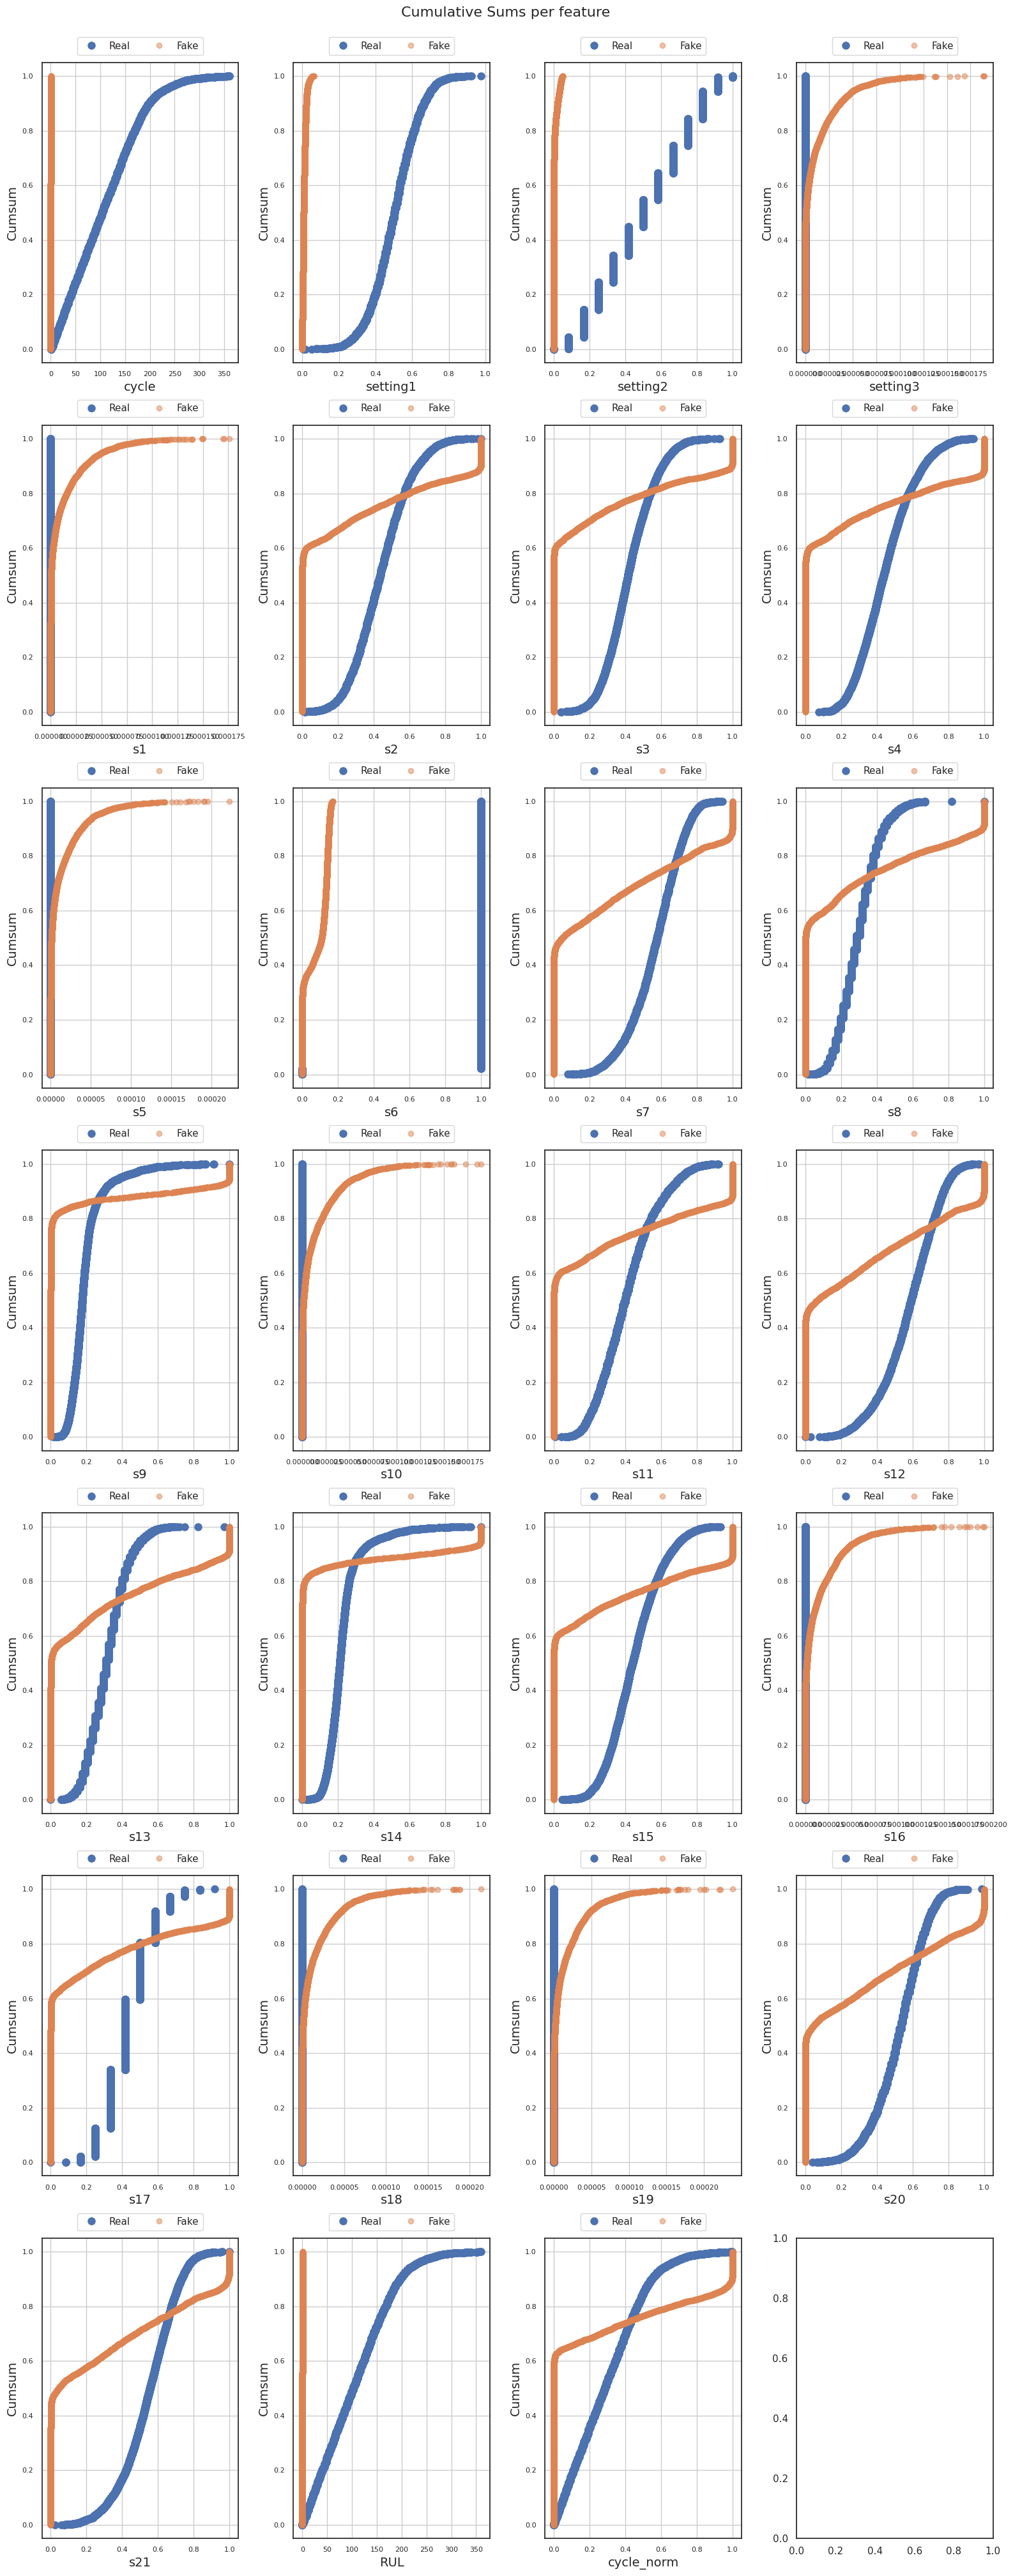

KeyboardInterrupt: 

In [24]:
from table_evaluator import TableEvaluator

table_evaluator =  TableEvaluator(data_df, synthetic_data_df)

table_evaluator.visual_evaluation()